In [9]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
MOVIES = r"C:\Users\udval\Downloads\archive\netflix_movies_detailed_up_to_2025.csv"
TV     = r"C:\Users\udval\Downloads\archive\netflix_tv_shows_detailed_up_to_2025.csv"

movies = pd.read_csv(MOVIES)
tv = pd.read_csv(TV)

movies["type"] = "Movie"
tv["type"] = "TV Show"

df = pd.concat([movies, tv], ignore_index=True)

keep = ["title", "type", "release_year", "rating", "country", "genres", "vote_count"]
df = df[keep]

df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")
df["vote_count"] = pd.to_numeric(df["vote_count"], errors="coerce").fillna(0).astype("int64")

df = df.dropna(subset=["title", "type", "release_year", "rating", "country", "genres"])
df = df[df["rating"] > 0]

this_year = datetime.now().year
df.loc[df["release_year"] > this_year, "release_year"] = this_year

for c in ["title", "country", "genres"]:
    df[c] = (df[c].astype(str)
                      .str.strip()
                      .str.replace(r"\s+", " ", regex=True))

df.insert(0, "content_id", range(1, len(df) + 1))
MIN_VOTES = 100
C = df.loc[df["vote_count"] > 0, "rating"].mean()
m = float(MIN_VOTES)

df["weighted_rating"] = ((df["vote_count"] / (df["vote_count"] + m)) * df["rating"]
                         + (m / (df["vote_count"] + m)) * C).round(3)

#### Top Genres Globally

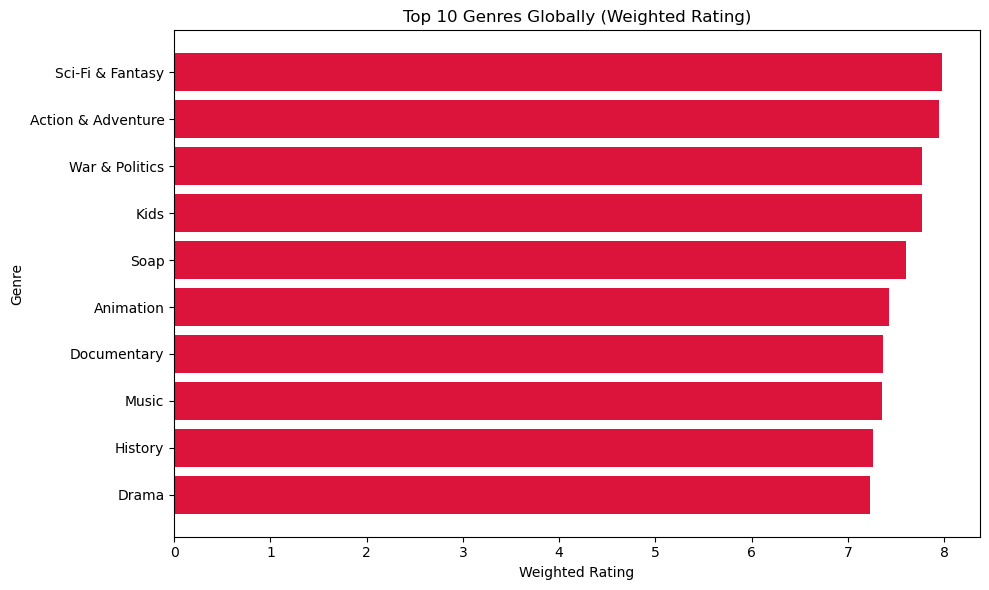

In [11]:
genres_split = df.assign(genres=df['genres'].str.split(',')).explode('genres')
genres_split['genres'] = genres_split['genres'].str.strip()
genres_split = genres_split[genres_split['genres'] != "Unknown"]

g = genres_split.copy()
g['rvx'] = g['rating'] * g['vote_count']

genre_stats = (g.groupby('genres')
               .agg(total_titles=('title','count'),
                    avg_rating=('rating','mean'),
                    total_votes=('vote_count','sum'),
                    num=('rvx','sum'))
               .reset_index())
genre_stats['weighted_rating'] = genre_stats['num'] / genre_stats['total_votes'].replace(0, np.nan)

top_genres = (genre_stats[(genre_stats['total_titles']>=100) & (genre_stats['total_votes']>0)]
              .sort_values(['weighted_rating','total_titles'], ascending=[False,False])
              .head(10))

plt.figure(figsize=(10, 6))
plt.barh(top_genres['genres'], top_genres['weighted_rating'], color='crimson')
plt.gca().invert_yaxis()
plt.title("Top 10 Genres Globally (Weighted Rating)")
plt.xlabel("Weighted Rating")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

#### Country Performance

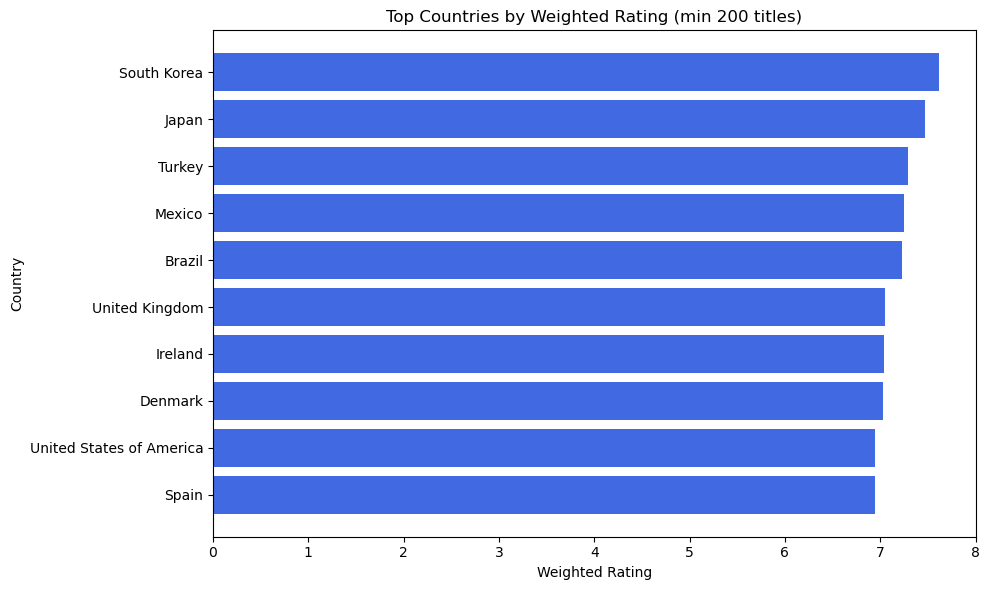

In [12]:
countries_split = df.assign(country=df['country'].str.split(',')).explode('country')
countries_split['country'] = countries_split['country'].str.strip()
countries_split = countries_split[countries_split['country'] != "Unknown"]

c = countries_split.copy()
c['rvx'] = c['rating'] * c['vote_count']

country_stats = (c.groupby('country')
                 .agg(total_titles=('title','count'),
                      avg_rating=('rating','mean'),
                      total_votes=('vote_count','sum'),
                      num=('rvx','sum'))
                 .reset_index())
country_stats['weighted_rating'] = country_stats['num'] / country_stats['total_votes'].replace(0, np.nan)

top_countries = (country_stats[(country_stats['total_titles']>=200) & (country_stats['total_votes']>0)]
                 .sort_values(['weighted_rating','total_titles'], ascending=[False,False])
                 .head(10))

plt.figure(figsize=(10, 6))
plt.barh(top_countries['country'], top_countries['weighted_rating'], color='royalblue')
plt.gca().invert_yaxis()
plt.title("Top Countries by Weighted Rating (min 200 titles)")
plt.xlabel("Weighted Rating")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

#### Strategy Over Time: Movies vs TV by Year

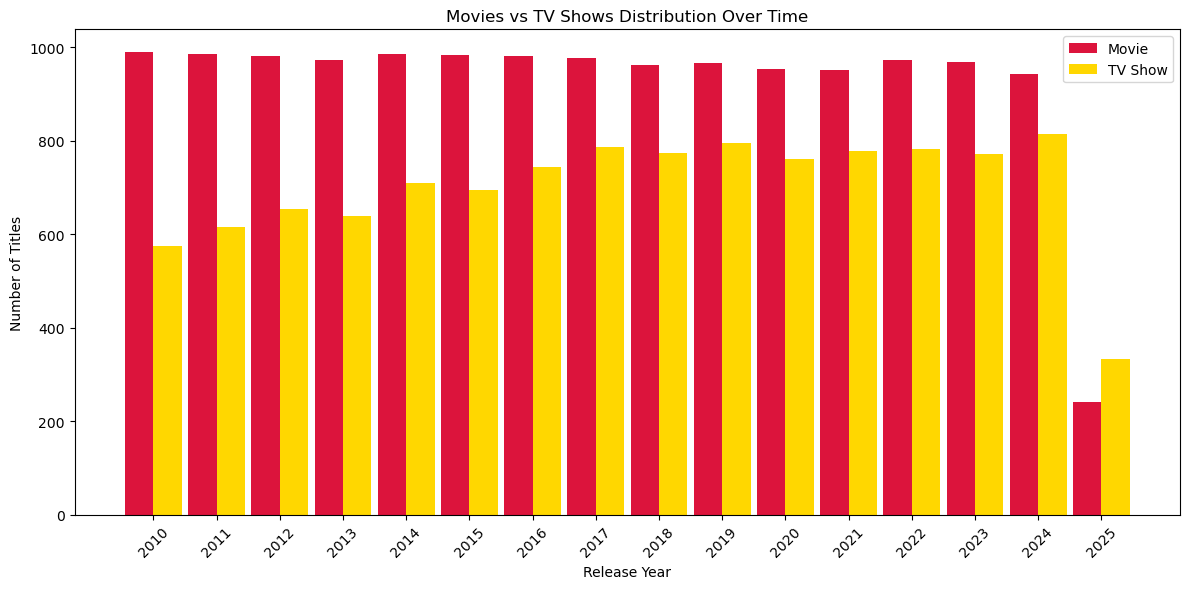

In [13]:
yearly_dist = (df.groupby(['release_year','type'])
               .size()
               .reset_index(name='count'))

pivot = yearly_dist.pivot(index='release_year', columns='type', values='count').fillna(0)
pivot = pivot.reindex(columns=['Movie','TV Show'])

x = np.arange(len(pivot.index))
w = 0.45

plt.figure(figsize=(12,6))
plt.bar(x - w/2, pivot['Movie'].values, width=w, label='Movie', color='crimson')
plt.bar(x + w/2, pivot['TV Show'].values, width=w, label='TV Show', color='gold')
plt.xticks(x, pivot.index, rotation=45)
plt.title("Movies vs TV Shows Distribution Over Time")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.legend()
plt.tight_layout()
plt.show()

#### High-Value Titles: Top 5 genres per type → Top 3 titles

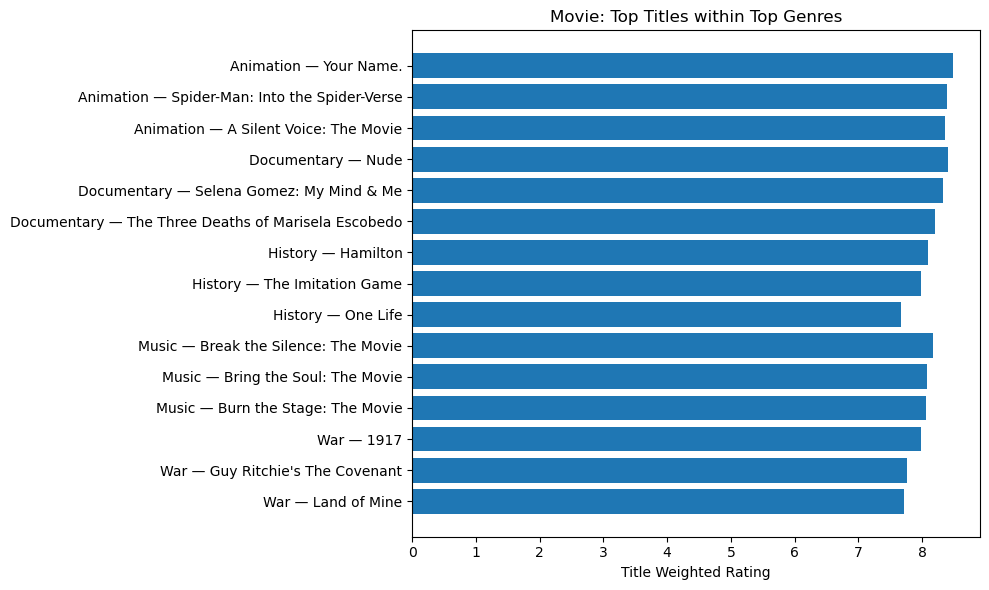

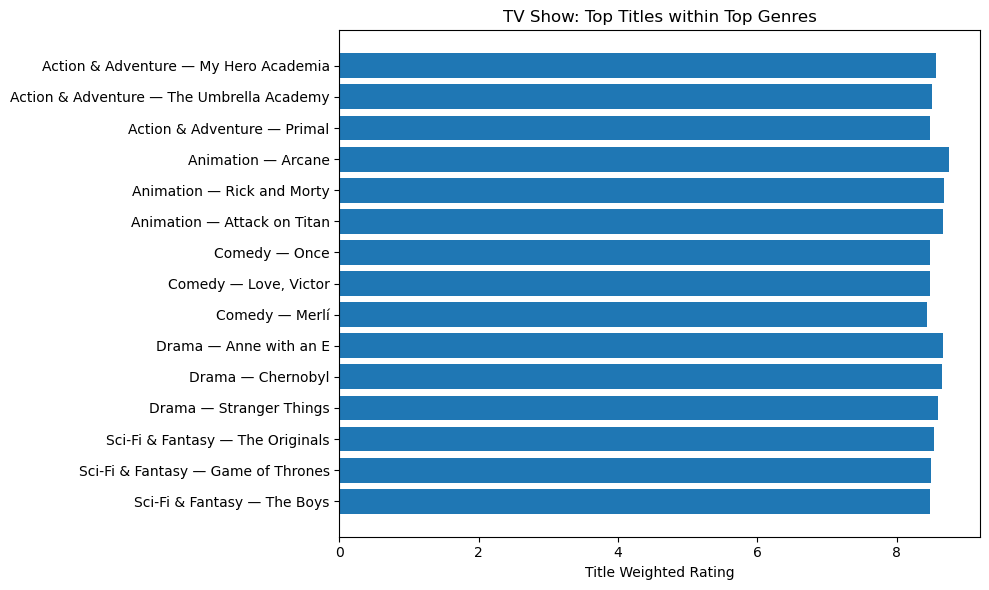

In [15]:
gl = genres_split.rename(columns={'genres': 'genre'}).copy()

# per (type, genre) vote-weighted score
gl['rvx'] = gl['rating'] * gl['vote_count']
tg = (gl.groupby(['type','genre'], as_index=False)
        .agg(n_titles    = ('title','count'),
             avg_rating  = ('rating','mean'),
             total_votes = ('vote_count','sum'),
             num         = ('rvx','sum')))
tg['weighted_rating'] = tg['num'] / tg['total_votes'].replace(0, np.nan)
tg = tg.drop(columns='num')
tg = tg[(tg['n_titles'] >= 100) & (tg['total_votes'] > 0)]
tg = tg.sort_values(['type','weighted_rating','n_titles'], ascending=[True,False,False])

# top 5 genres per type
top5_by_type = tg.groupby('type', as_index=False).head(5)

# per-title weighted score with smoothing (same MIN_VOTES/C as above)
MIN_VOTES = 100
C = df.loc[df['vote_count'] > 0, 'rating'].mean()
m = float(MIN_VOTES)
gl['title_wr'] = (gl['vote_count']/(gl['vote_count']+m))*gl['rating'] + (m/(gl['vote_count']+m))*C

# pick best genre per (type, title) to avoid duplicates across multiple genres
gl = gl.sort_values(['type','title','title_wr','vote_count','release_year'],
                    ascending=[True,True,False,False,False])
gl['genre_pick'] = gl.groupby(['type','title']).cumcount() + 1
best_genre_title = gl[gl['genre_pick'] == 1].drop(columns=['genre_pick','rvx'])

# keep only titles that belong to the top-5 genres per type
mask = best_genre_title.merge(top5_by_type[['type','genre']], on=['type','genre'], how='inner')

# rank titles within each (type, genre)
mask = mask.sort_values(['type','genre','title_wr','vote_count','release_year'],
                        ascending=[True,True,False,False,False])
mask['rnk'] = mask.groupby(['type','genre']).cumcount() + 1
top_titles = mask[mask['rnk'] <= 3].copy()

# simple plots (show in notebook)
def plot_top_titles(df_titles, typ):
    s = df_titles[df_titles['type'] == typ].copy()
    s['label'] = s['genre'] + " — " + s['title'].str.slice(0, 40)
    plt.figure(figsize=(10,6))
    plt.barh(s['label'], s['title_wr'].round(3))
    plt.gca().invert_yaxis()
    plt.title(f"{typ}: Top Titles within Top Genres")
    plt.xlabel("Title Weighted Rating")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

plot_top_titles(top_titles, "Movie")
plot_top_titles(top_titles, "TV Show")